In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set paths
sys.path.extend([
    os.path.abspath(os.path.join("../..")),
    os.path.abspath(os.path.join("../../../BayesFlow_dev/BayesFlow/"))
])

# Import from relative paths
from src.python.helpers import load_empirical_rt_data, join_and_fill_missings, get_latex_results_table
from src.python.ensemble import get_ensemble_predictions, get_pmps_under_scaling, get_pmps_under_scaling_bootstrapping
from src.python.settings import plotting_settings, plotting_update
from src.python.visualization import plot_color_grid, plot_prior_sensitivity, plot_sensitivity_posteriors

In [3]:
plt.rcParams.update(plotting_update)

# Approximator Sensitivity: Ensemble Predictions without Scaling

In [4]:
# Setup 
POWER_SCALINGS = [True, False]
NUM_MODELS = 4
FIXED_SCALING_FACTORS = np.array([1.0, 1.0], dtype=np.float32)[np.newaxis, :]
SUMMARY_DIM = 64
MODEL_LABELS = ["$\mathcal{M}_1$", "$\mathcal{M}_2$", "$\mathcal{M}_3$", "$\mathcal{M}_4$"]

In [5]:
# Load data from folders
parent_folder = os.path.dirname(os.path.dirname(os.getcwd()))
color_folder = os.path.join(
    parent_folder, "data/levy_comparison/data_rts/color"
)
lexical_folder = os.path.join(
    parent_folder, "data/levy_comparison/data_rts/lexical"
)

color_data = load_empirical_rt_data(color_folder)
lexical_data = load_empirical_rt_data(lexical_folder)

# Join experimental data and fill missing values
empirical_data = join_and_fill_missings(
    color_data, lexical_data, n_trials=900, missing_rts_equal_mean=True
)

In [6]:
# Get predictions
try: 
    with open("../../data/levy_comparison/predictions/preds_emp_powerscaled.pkl", "rb") as file:
        scaled_emp_dict = pickle.load(file)

    with open("../../data/levy_comparison/predictions/preds_emp_unscaled.pkl", "rb") as file:
        unscaled_emp_dict = pickle.load(file)
    
except:
    os.makedirs("../../data/levy_comparison/predictions", exist_ok=True)
    
    for power_scaling in POWER_SCALINGS:
        scaling_name = "sim_powerscaled" if power_scaling else "sim_unscaled"

        data = {"summary_conditions": empirical_data}
        if power_scaling:
            data["direct_conditions"] = FIXED_SCALING_FACTORS
        else:
            data["direct_conditions"] = None

        embeddings, pmps, logits = get_ensemble_predictions(
            path=f"ensemble_checkpoints/{scaling_name}", 
            data=data, 
            num_models=NUM_MODELS,
            summary_dim=SUMMARY_DIM
        )
    
        pred_dict = {
            "preds": pmps,
            "logits": logits,
            "summary_output": embeddings
        }

        with open(f"../../data/levy_comparison/predictions/preds_emp_{scaling_name[4:]}.pkl", "wb") as file:
            pickle.dump(pred_dict, file)

    with open("../../data/levy_comparison/predictions/preds_emp_powerscaled.pkl", "rb") as file:
        scaled_emp_dict = pickle.load(file)

    with open("../../data/levy_comparison/predictions/preds_emp_unscaled.pkl", "rb") as file:
        unscaled_emp_dict = pickle.load(file)

In [7]:
# Get validation results
with open("../../data/levy_comparison/validation_results/validation_scaled_unscaled.pkl", "rb") as file:
    val_results_dict = pickle.load(file)

In [8]:
# Scaled ensemble: Combine validation results with predictions
df_scaled = pd.DataFrame(scaled_emp_dict["preds"][:, 0, :], columns=MODEL_LABELS)
df_scaled.index = [f'Network {i}' for i in range(1, scaled_emp_dict["preds"].shape[0] + 1)]

combined_df_scaled = pd.concat([val_results_dict["scaled"], df_scaled], axis=1)
get_latex_results_table(combined_df_scaled)

\begin{table}[h]
\centering
\begin{tabular}{lrrrrrrrr}
\toprule
 & ECE & Brier Score & MAE & Accuracy & $\mathcal{M}_1$ & $\mathcal{M}_2$ & $\mathcal{M}_3$ & $\mathcal{M}_4$ \\
\midrule
Network 1 & 0.01 & 0.01 & 0.02 & 0.99 & 0.00 & 0.00 & 1.00 & 0.00 \\
Network 2 & 0.01 & 0.03 & 0.05 & 0.96 & 0.00 & 0.00 & 0.92 & 0.08 \\
Network 3 & 0.01 & 0.01 & 0.01 & 0.99 & 0.00 & 0.00 & 0.17 & 0.83 \\
Network 4 & 0.01 & 0.01 & 0.01 & 0.99 & 0.00 & 0.00 & 0.50 & 0.50 \\
Network 5 & 0.01 & 0.01 & 0.01 & 0.99 & 0.00 & 0.00 & 0.96 & 0.04 \\
Network 6 & 0.01 & 0.01 & 0.01 & 0.99 & 0.00 & 0.00 & 0.02 & 0.98 \\
Network 7 & 0.01 & 0.01 & 0.01 & 0.99 & 0.00 & 0.00 & 0.75 & 0.25 \\
Network 8 & 0.01 & 0.01 & 0.02 & 0.99 & 0.00 & 0.00 & 1.00 & 0.00 \\
Network 9 & 0.01 & 0.01 & 0.01 & 0.99 & 0.52 & 0.03 & 0.25 & 0.21 \\
Network 10 & 0.01 & 0.02 & 0.03 & 0.97 & 0.00 & 0.00 & 0.85 & 0.15 \\
Network 11 & 0.01 & 0.01 & 0.01 & 0.99 & 0.00 & 0.00 & 0.37 & 0.63 \\
Network 12 & 0.01 & 0.01 & 0.01 & 0.99 & 0.00 & 0.00 

In [9]:
get_latex_results_table(combined_df_scaled, precision=3)

\begin{table}[h]
\centering
\begin{tabular}{lrrrrrrrr}
\toprule
 & ECE & Brier Score & MAE & Accuracy & $\mathcal{M}_1$ & $\mathcal{M}_2$ & $\mathcal{M}_3$ & $\mathcal{M}_4$ \\
\midrule
Network 1 & 0.009 & 0.012 & 0.017 & 0.985 & 0.000 & 0.000 & 0.997 & 0.003 \\
Network 2 & 0.012 & 0.028 & 0.048 & 0.962 & 0.000 & 0.000 & 0.917 & 0.082 \\
Network 3 & 0.007 & 0.009 & 0.012 & 0.989 & 0.000 & 0.001 & 0.165 & 0.834 \\
Network 4 & 0.005 & 0.006 & 0.007 & 0.993 & 0.000 & 0.000 & 0.504 & 0.496 \\
Network 5 & 0.008 & 0.010 & 0.014 & 0.987 & 0.000 & 0.000 & 0.957 & 0.043 \\
Network 6 & 0.008 & 0.010 & 0.014 & 0.988 & 0.000 & 0.000 & 0.024 & 0.976 \\
Network 7 & 0.008 & 0.010 & 0.014 & 0.988 & 0.000 & 0.000 & 0.752 & 0.248 \\
Network 8 & 0.009 & 0.012 & 0.017 & 0.985 & 0.000 & 0.000 & 0.995 & 0.005 \\
Network 9 & 0.008 & 0.009 & 0.011 & 0.990 & 0.518 & 0.026 & 0.248 & 0.209 \\
Network 10 & 0.012 & 0.021 & 0.034 & 0.972 & 0.000 & 0.000 & 0.847 & 0.153 \\
Network 11 & 0.007 & 0.009 & 0.013 & 0.989 

In [10]:
# Unscaled ensemble: Combine validation results with predictions
df_unscaled = pd.DataFrame(unscaled_emp_dict["preds"][:, 0, :], columns=MODEL_LABELS)
df_unscaled.index = [f'Network {i}' for i in range(1, unscaled_emp_dict["preds"].shape[0] + 1)]

combined_df_unscaled = pd.concat([val_results_dict["unscaled"], df_unscaled], axis=1)
get_latex_results_table(combined_df_unscaled)

\begin{table}[h]
\centering
\begin{tabular}{lrrrrrrrr}
\toprule
 & ECE & Brier Score & MAE & Accuracy & $\mathcal{M}_1$ & $\mathcal{M}_2$ & $\mathcal{M}_3$ & $\mathcal{M}_4$ \\
\midrule
Network 1 & 0.00 & 0.00 & 0.00 & 1.00 & 0.00 & 0.00 & 0.01 & 0.99 \\
Network 2 & 0.00 & 0.01 & 0.01 & 0.99 & 0.00 & 0.00 & 0.00 & 1.00 \\
Network 3 & 0.01 & 0.01 & 0.02 & 0.98 & 0.00 & 0.00 & 0.99 & 0.01 \\
Network 4 & 0.01 & 0.02 & 0.03 & 0.98 & 0.00 & 0.00 & 0.60 & 0.40 \\
Network 5 & 0.01 & 0.01 & 0.03 & 0.98 & 0.00 & 0.00 & 0.88 & 0.12 \\
Network 6 & 0.00 & 0.00 & 0.00 & 1.00 & 1.00 & 0.00 & 0.00 & 0.00 \\
Network 7 & 0.00 & 0.00 & 0.00 & 1.00 & 0.00 & 0.00 & 0.00 & 1.00 \\
Network 8 & 0.01 & 0.01 & 0.02 & 0.98 & 0.00 & 0.00 & 0.00 & 1.00 \\
Network 9 & 0.00 & 0.00 & 0.00 & 1.00 & 0.00 & 1.00 & 0.00 & 0.00 \\
Network 10 & 0.00 & 0.00 & 0.00 & 1.00 & 0.72 & 0.16 & 0.11 & 0.00 \\
Network 11 & 0.00 & 0.00 & 0.00 & 1.00 & 0.01 & 0.42 & 0.00 & 0.56 \\
Network 12 & 0.01 & 0.02 & 0.04 & 0.97 & 0.00 & 0.00 

In [11]:
get_latex_results_table(combined_df_unscaled, precision=3)

\begin{table}[h]
\centering
\begin{tabular}{lrrrrrrrr}
\toprule
 & ECE & Brier Score & MAE & Accuracy & $\mathcal{M}_1$ & $\mathcal{M}_2$ & $\mathcal{M}_3$ & $\mathcal{M}_4$ \\
\midrule
Network 1 & 0.003 & 0.003 & 0.004 & 0.996 & 0.000 & 0.000 & 0.007 & 0.993 \\
Network 2 & 0.004 & 0.005 & 0.007 & 0.994 & 0.000 & 0.000 & 0.000 & 1.000 \\
Network 3 & 0.009 & 0.012 & 0.018 & 0.984 & 0.000 & 0.000 & 0.990 & 0.010 \\
Network 4 & 0.008 & 0.018 & 0.030 & 0.977 & 0.000 & 0.000 & 0.601 & 0.399 \\
Network 5 & 0.006 & 0.014 & 0.025 & 0.981 & 0.000 & 0.000 & 0.881 & 0.119 \\
Network 6 & 0.002 & 0.002 & 0.002 & 0.998 & 0.997 & 0.003 & 0.000 & 0.000 \\
Network 7 & 0.003 & 0.003 & 0.004 & 0.997 & 0.000 & 0.001 & 0.000 & 0.999 \\
Network 8 & 0.009 & 0.014 & 0.020 & 0.982 & 0.000 & 0.000 & 0.000 & 1.000 \\
Network 9 & 0.002 & 0.002 & 0.003 & 0.997 & 0.000 & 0.998 & 0.000 & 0.001 \\
Network 10 & 0.002 & 0.003 & 0.003 & 0.997 & 0.725 & 0.160 & 0.114 & 0.001 \\
Network 11 & 0.003 & 0.003 & 0.004 & 0.996 

# Approximator + Prior Sensitivity: Ensemble Predictions under Scaling

In [10]:
NUM_ENSEMBLE_MEMBERS = scaled_emp_dict["preds"].shape[0]

LOWER_BOUND = 0.1
UPPER_BOUND = 10
NUM_FACTORS = 9

factors = np.exp(np.linspace(np.log(LOWER_BOUND), np.log(UPPER_BOUND), NUM_FACTORS))
factors

array([ 0.1       ,  0.17782794,  0.31622777,  0.56234133,  1.        ,
        1.77827941,  3.16227766,  5.62341325, 10.        ])

In [11]:
try: 
    with open(f"../../data/levy_comparison/predictions/preds_emp_scaled.pkl", "rb") as file:
        results_under_scaling = pickle.load(file)
    
except:
    results_under_scaling = get_pmps_under_scaling(
        factors=factors, 
        empirical_data=empirical_data, 
        num_ensemble_members=NUM_ENSEMBLE_MEMBERS, 
        path="ensemble_checkpoints/sim_powerscaled"
    )

    with open(f"../../data/levy_comparison/predictions/preds_emp_scaled.pkl", "wb") as file:
        pickle.dump(results_under_scaling, file)

    with open(f"../../data/levy_comparison/predictions/preds_emp_scaled.pkl", "rb") as file:
        results_under_scaling = pickle.load(file)

In [12]:
pd.DataFrame(results_under_scaling)

,0,1,2,3,4,5,6
0,0.1,0.100000,0.0,2.513036e-07,5.111475e-07,0.968520,0.031479
1,0.1,0.177828,0.0,2.527818e-07,5.127355e-07,0.968612,0.031387
2,0.1,0.316228,0.0,2.555190e-07,5.171179e-07,0.968724,0.031275
3,0.1,0.562341,0.0,2.611687e-07,5.258351e-07,0.968929,0.031070
4,0.1,1.000000,0.0,2.701659e-07,5.388823e-07,0.969306,0.030693
...,...,...,...,...,...,...,...
1615,10.0,1.000000,19.0,3.533543e-06,4.307728e-06,0.718552,0.281440
1616,10.0,1.778279,19.0,3.668841e-06,4.848527e-06,0.708748,0.291244
1617,10.0,3.162278,19.0,3.933912e-06,5.969258e-06,0.692382,0.307608
1618,10.0,5.623413,19.0,4.573299e-06,8.691757e-06,0.666515,0.333471


# Approximator + Prior + Data Sensitivity: Ensemble Predictions under Scaling and Bootstrapped Trials

In [13]:
# Bootstrapping with powerscaling
try: 
    with open(f"../../data/levy_comparison/predictions/preds_emp_scaled_bootstrapped.pkl", "rb") as file:
        results_under_scaling_bootstrapping = pickle.load(file)
    
except:
    results_under_scaling_bootstrapping = get_pmps_under_scaling_bootstrapping(
        factors=factors, 
        empirical_data=empirical_data,
        num_ensemble_members=NUM_ENSEMBLE_MEMBERS,
        level="trials", 
        num_bootstrap=100
    )

    with open(f"../../data/levy_comparison/predictions/preds_emp_scaled_bootstrapped.pkl", "wb") as file:
        pickle.dump(results_under_scaling_bootstrapping, file)

    with open(f"../../data/levy_comparison/predictions/preds_emp_scaled_bootstrapped.pkl", "rb") as file:
        results_under_scaling_bootstrapping = pickle.load(file)

In [14]:
# Bootstrapping without powerscaling

fixed_factors = [1.0]

try: 
    with open(f"../../data/levy_comparison/predictions/preds_emp_bootstrapped.pkl", "rb") as file:
        results_under_bootstrapping = pickle.load(file)
    
except:
    results_under_bootstrapping = get_pmps_under_scaling_bootstrapping(
        factors=fixed_factors, 
        empirical_data=empirical_data,
        num_ensemble_members=NUM_ENSEMBLE_MEMBERS,
        level="trials", 
        num_bootstrap=100
    )

    with open(f"../../data/levy_comparison/predictions/preds_emp_bootstrapped.pkl", "wb") as file:
        pickle.dump(results_under_bootstrapping, file)

    with open(f"../../data/levy_comparison/predictions/preds_emp_bootstrapped.pkl", "rb") as file:
        results_under_bootstrapping = pickle.load(file)

# Visualize sensitivity

In [15]:
# Align data formats
#pmps_single_net = scaled_emp_dict["preds"][0, 0, :]  # use first neural net
pmps_single_net = [0.00007515, 0.01163833, 0.7806216 , 0.20766494]  # use original results from Elsemüller et. al (2023)
pmps_ensemble = scaled_emp_dict["preds"][:, 0, :]
pmps_ensemble_scaling = results_under_scaling[:, 3:]
pmps_ensemble_bootstrapping = np.concatenate(results_under_bootstrapping)[:, 3:]
pmps_ensemble_scaling_bootstrapping = np.concatenate(results_under_scaling_bootstrapping)[:, 3:]

## Prior Sensitivity Heatmap

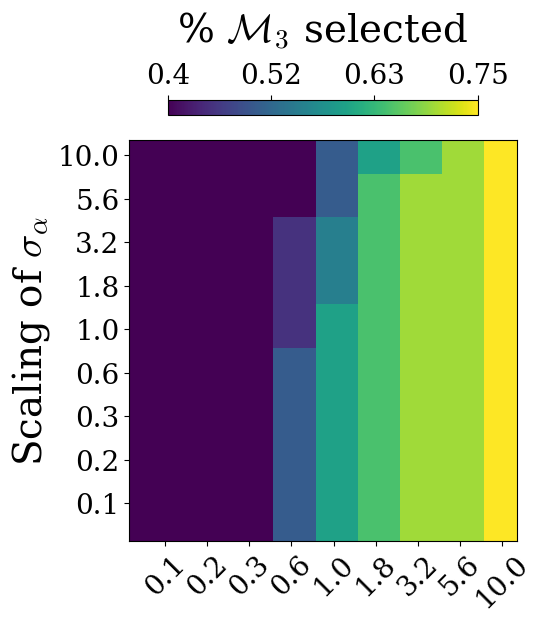

In [16]:
# % M3 selected

# Initialize a result array to store the means
grid_m4_selected = np.zeros((NUM_FACTORS, NUM_FACTORS))

# Loop through unique combinations and calculate the mean for each
for i, f1 in enumerate(factors):
    for j, f2 in enumerate(factors):
        mask = (results_under_scaling[:, 0] == f1) & (results_under_scaling[:, 1] == f2)
        grid_m4_selected[i, j] = np.mean(np.argmax(pmps_ensemble_scaling[mask], axis=1) == 2)

# Create the grids
x_grid, y_grid = np.meshgrid(factors, factors, indexing="ij")
z_grid = grid_m4_selected

plot_color_grid(
    x_grid=x_grid,
    y_grid=y_grid,
    z_grid=z_grid,
    cmap="viridis",
    xlabel=None,
    ylabel=r"Scaling of $\mathcal{\sigma}_{\alpha}$",
    xticks=factors,
    yticks=factors,
    cbar_title=r"% $\mathcal{M}_3$ selected",
)

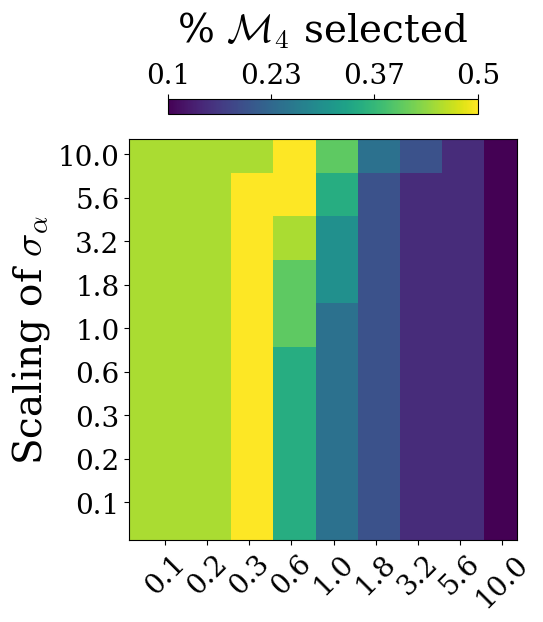

In [17]:
# % M4 selected

# Initialize a result array to store the means
grid_m4_selected = np.zeros((NUM_FACTORS, NUM_FACTORS))

# Loop through unique combinations and calculate the mean for each
for i, f1 in enumerate(factors):
    for j, f2 in enumerate(factors):
        mask = (results_under_scaling[:, 0] == f1) & (results_under_scaling[:, 1] == f2)
        grid_m4_selected[i, j] = np.mean(np.argmax(pmps_ensemble_scaling[mask], axis=1) == 3)

# Create the grids
x_grid, y_grid = np.meshgrid(factors, factors, indexing="ij")
z_grid = grid_m4_selected

plot_color_grid(
    x_grid=x_grid,
    y_grid=y_grid,
    z_grid=z_grid,
    cmap="viridis",
    xlabel=None,
    ylabel=r"Scaling of $\mathcal{\sigma}_{\alpha}$",
    xticks=factors,
    yticks=factors,
    cbar_title=r"% $\mathcal{M}_4$ selected",
)

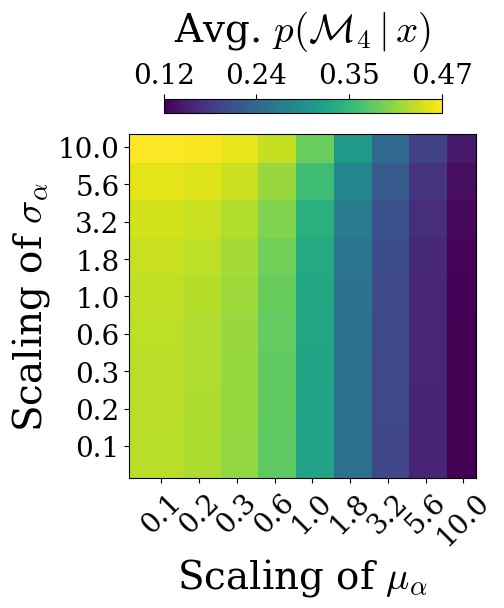

In [28]:
# Plot prior sensitivity for M4
fig, ax = plt.subplots(1, 1, figsize=(4.4, 5))
fig.tight_layout()

plot_prior_sensitivity(
    factors_1=results_under_scaling[:, 0],
    factors_2=results_under_scaling[:, 1],
    factor_list=factors,
    pmps=pmps_ensemble_scaling,
    num_ensemble_members=NUM_ENSEMBLE_MEMBERS,
    cmap="viridis",
    xlabel=r"Scaling of $\mathcal{\mu}_{\alpha}$",
    ylabel=r"Scaling of $\mathcal{\sigma}_{\alpha}$",
    show_yticks=True,
    cbar_title=r"Avg. $p(\mathcal{M}_4\,|\,x)$",
    ax=ax,
    target_model_for_avg=4
)

plt.savefig("../../figures/levy_prior_sensitivity_avgm4.pdf", dpi=300, bbox_inches="tight")

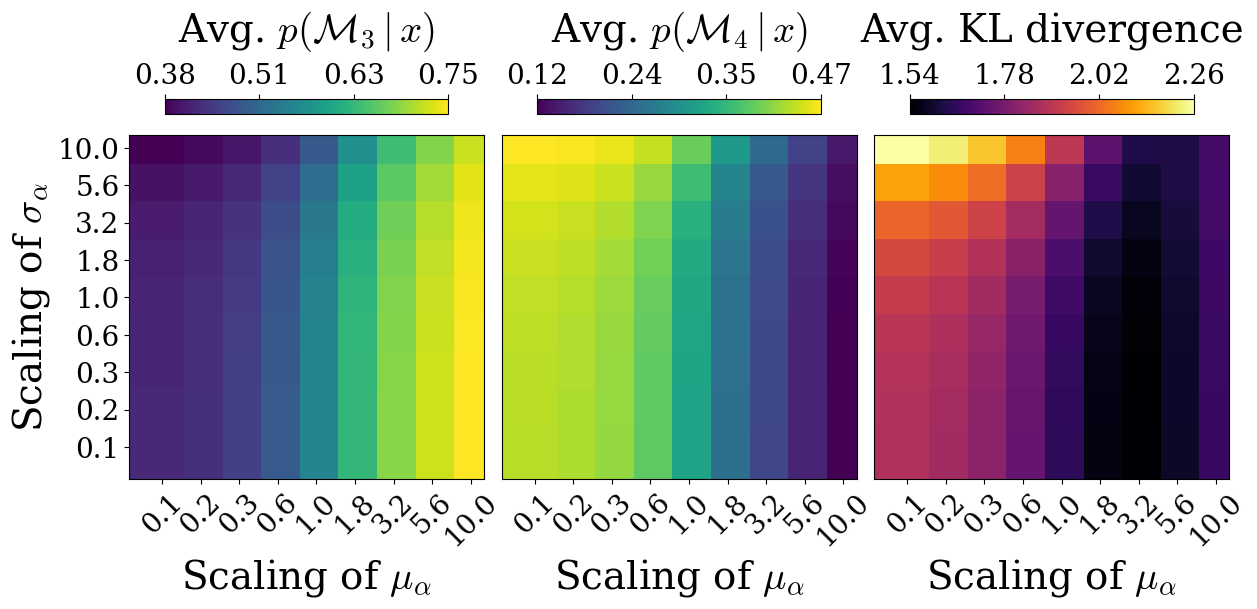

In [32]:
# Plot prior sensitivity for M3, M4, and KL divergence
fig, axarr = plt.subplots(1, 3, figsize=(12, 5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)

plot_prior_sensitivity(
    factors_1=results_under_scaling[:, 0],
    factors_2=results_under_scaling[:, 1],
    factor_list=factors,
    pmps=pmps_ensemble_scaling,
    num_ensemble_members=NUM_ENSEMBLE_MEMBERS,
    cmap="viridis",
    xlabel=r"Scaling of $\mathcal{\mu}_{\alpha}$",
    ylabel=r"Scaling of $\mathcal{\sigma}_{\alpha}$",
    show_yticks=True,
    cbar_title=r"Avg. $p(\mathcal{M}_3\,|\,x)$",
    ax=axarr[0],
    target_model_for_avg=3
)

plot_prior_sensitivity(
    factors_1=results_under_scaling[:, 0],
    factors_2=results_under_scaling[:, 1],
    factor_list=factors,
    pmps=pmps_ensemble_scaling,
    num_ensemble_members=NUM_ENSEMBLE_MEMBERS,
    cmap="viridis",
    xlabel=r"Scaling of $\mathcal{\mu}_{\alpha}$",
    ylabel=None,
    show_yticks=False,
    cbar_title=r"Avg. $p(\mathcal{M}_4\,|\,x)$",
    ax=axarr[1],
    target_model_for_avg=4
)

plot_prior_sensitivity(
    factors_1=results_under_scaling[:, 0],
    factors_2=results_under_scaling[:, 1],
    factor_list=factors,
    pmps=pmps_ensemble_scaling,
    num_ensemble_members=NUM_ENSEMBLE_MEMBERS,
    cmap="inferno",
    xlabel=r"Scaling of $\mathcal{\mu}_{\alpha}$",
    ylabel=None,
    show_yticks=False,
    cbar_title=r"Avg. KL divergence",#$\mathrm{KL}(P\;||\,P_{scaled})$",
    ax=axarr[2],
    reference_pmps=pmps_single_net
)

plt.savefig("../../figures/levy_prior_sensitivity_talk.png", dpi=300, bbox_inches="tight")

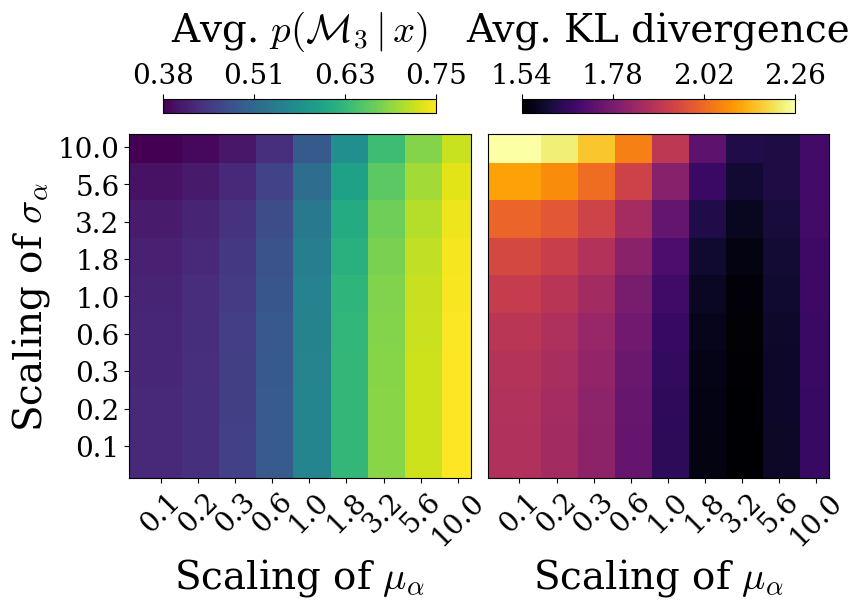

In [29]:
# Plot prior sensitivity for M3 and KL divergence
fig, axarr = plt.subplots(1, 2, figsize=(8, 5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.05)

plot_prior_sensitivity(
    factors_1=results_under_scaling[:, 0],
    factors_2=results_under_scaling[:, 1],
    factor_list=factors,
    pmps=pmps_ensemble_scaling,
    num_ensemble_members=NUM_ENSEMBLE_MEMBERS,
    cmap="viridis",
    xlabel=r"Scaling of $\mathcal{\mu}_{\alpha}$",
    ylabel=r"Scaling of $\mathcal{\sigma}_{\alpha}$",
    show_yticks=True,
    cbar_title=r"Avg. $p(\mathcal{M}_3\,|\,x)$",
    ax=axarr[0],
    target_model_for_avg=3
)

plot_prior_sensitivity(
    factors_1=results_under_scaling[:, 0],
    factors_2=results_under_scaling[:, 1],
    factor_list=factors,
    pmps=pmps_ensemble_scaling,
    num_ensemble_members=NUM_ENSEMBLE_MEMBERS,
    cmap="inferno",
    xlabel=r"Scaling of $\mathcal{\mu}_{\alpha}$",
    ylabel=None,
    show_yticks=False,
    cbar_title=r"Avg. KL divergence",#$\mathrm{KL}(P\;||\,P_{scaled})$",
    ax=axarr[1],
    reference_pmps=pmps_single_net
)

plt.savefig("../../figures/levy_prior_sensitivity.pdf", dpi=300, bbox_inches="tight")

In [33]:
# Quick check whether avg. M3 probs correspond to avg. PMP plot
# 0.1, 0.1
mask = (results_under_scaling[:, 0] == factors[1]) & (results_under_scaling[:, 1] == factors[1])
print(np.mean(results_under_scaling[mask, 5]))

# 0.1, 10
mask = (results_under_scaling[:, 0] == factors[1]) & (results_under_scaling[:, 1] == factors[-1])
print(np.mean(results_under_scaling[mask, 5]))

# 10, 10
mask = (results_under_scaling[:, 0] == factors[-1]) & (results_under_scaling[:, 1] == factors[-1])
print(np.mean(results_under_scaling[mask, 5]))

# 10, 0.1
mask = (results_under_scaling[:, 0] == factors[-1]) & (results_under_scaling[:, 1] == factors[1])
print(np.mean(results_under_scaling[mask, 5]))

0.43475474230251476
0.39250241558085863
0.7197144136040606
0.7494045695139363


In [34]:
pmps_ensemble_scaling_bootstrapping.shape

(162000, 4)

## All Sensitivities

In [22]:
from scipy.stats import entropy
np.mean([
    entropy(pmps_single_net, pmps_ensemble[pred, :]) for pred in range(pmps_ensemble.shape[1])
])

0.5474978145201413

In [23]:
np.mean([
    entropy(pmps_single_net, pmps_ensemble_scaling[pred, :]) for pred in range(pmps_ensemble_scaling.shape[1])
])

0.3415135776260027

In [24]:
np.mean([
    entropy(pmps_single_net, pmps_ensemble_bootstrapping[pred, :]) for pred in range(pmps_ensemble_bootstrapping.shape[1])
])

1.6146283641998291

In [25]:
np.mean([
    entropy(pmps_single_net, pmps_ensemble_scaling_bootstrapping[pred, :]) for pred in range(pmps_ensemble_scaling_bootstrapping.shape[1])
])

0.31976619272623413

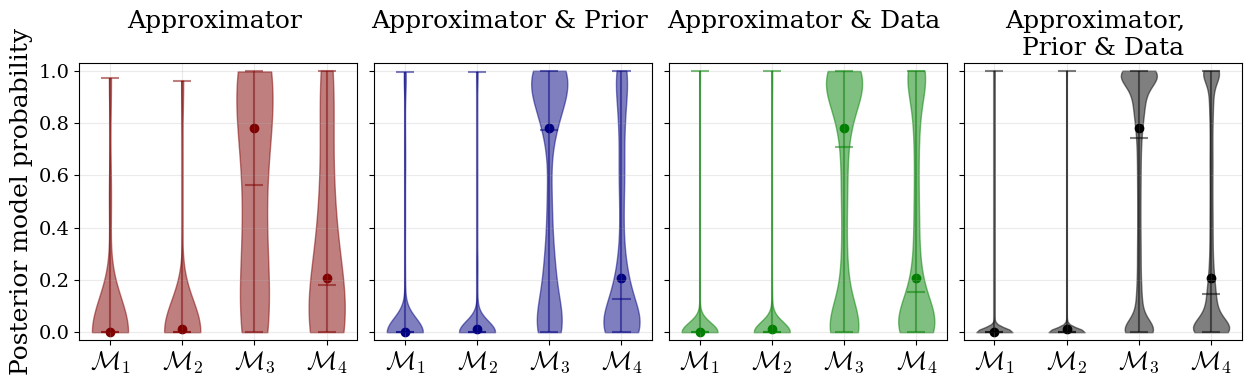

In [26]:
# Plot all sensitivities together - using median for horizontal bars
labels = ["$\mathcal{M}_1$", "$\mathcal{M}_2$", "$\mathcal{M}_3$", "$\mathcal{M}_4$"]
fig, axarr = plt.subplots(1, 4, figsize=(15, 3.6))
plt.subplots_adjust(wspace=0.06)
special_fontsize = 18

plot_sensitivity_posteriors(
    single_pmps=pmps_single_net,
    sensitivity_pmps=pmps_ensemble, 
    labels=labels, 
    color=plotting_settings["colors"][0], 
    alpha=0.5,
    fontsize_labels=special_fontsize,
    fontsize_ticks=14,
    fontsize_title=special_fontsize,
    ylabel=True, 
    title="Approximator \n", 
    save=False, 
    ax=axarr[0]
)

plot_sensitivity_posteriors(
    single_pmps=pmps_single_net,
    sensitivity_pmps=pmps_ensemble_scaling, 
    labels=labels, 
    color=plotting_settings["colors"][1], 
    alpha=0.5,
    fontsize_labels=special_fontsize,
    fontsize_ticks=20,
    fontsize_title=special_fontsize,
    ylabel=False, 
    title="Approximator & Prior \n", 
    save=False, 
    ax=axarr[1]
)

plot_sensitivity_posteriors(
    single_pmps=pmps_single_net,
    sensitivity_pmps=pmps_ensemble_bootstrapping, 
    labels=labels, 
    color=plotting_settings["colors"][2], 
    alpha=0.5,
    fontsize_labels=special_fontsize,
    fontsize_ticks=20,
    fontsize_title=special_fontsize,
    ylabel=False, 
    title="Approximator & Data \n", 
    save=False, 
    ax=axarr[2]
)

plot_sensitivity_posteriors(
    single_pmps=pmps_single_net,
    sensitivity_pmps=pmps_ensemble_scaling_bootstrapping, 
    labels=labels, 
    color="black", 
    alpha=0.5,
    fontsize_labels=special_fontsize,
    fontsize_ticks=20,
    fontsize_title=special_fontsize,
    ylabel=False, 
    title="Approximator,  \n Prior & Data ", 
    save=False, 
    ax=axarr[3]
)

plt.savefig("../../figures/levy_sensitivity.pdf", dpi=300, bbox_inches="tight")